In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.notebook import tqdm
sns.set(style="whitegrid")


In [2]:
import os
import shutil

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/leukemia-dataset-1/ALL_IDB2/img'  # Change this if needed

# Define a writable output directory for the new folders
output_dir = '/kaggle/working/leukemia-dataset-separated'  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")


Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [4]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])



In [5]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = '/kaggle/working/leukemia-dataset-separated'

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")



Train size: 182, Val size: 39, Test size: 39


In [6]:
import torch
import torch.nn as nn
from torchvision import models

class SmallCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SmallCell, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, input_size // 4),
            nn.ReLU(),
            nn.Linear(input_size // 4, 4 * hidden_size)
        )

    def forward(self, x):
        return self.seq(x)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout=0.1):
        super(LSTMCell, self).__init__()
        self.nlayers = nlayers
        self.dropout = nn.Dropout(p=dropout)

        ih, hh = [], []
        for i in range(nlayers):
            if i == 0:
                ih.append(SmallCell(input_size, hidden_size))
                hh.append(SmallCell(hidden_size, hidden_size))
            else:
                ih.append(nn.Linear(hidden_size, 4 * hidden_size))
                hh.append(nn.Linear(hidden_size, 4 * hidden_size))
        self.w_ih = nn.ModuleList(ih)
        self.w_hh = nn.ModuleList(hh)

    def forward(self, input, hidden):
        hy, cy = [], []
        for i in range(self.nlayers):
            hx, cx = hidden[0][i], hidden[1][i]
            gates = self.w_ih[i](input) + self.w_hh[i](hx)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)
            i_gate = torch.sigmoid(i_gate)
            f_gate = torch.sigmoid(f_gate)
            c_gate = torch.tanh(c_gate)
            o_gate = torch.sigmoid(o_gate)
            ncx = (f_gate * cx) + (i_gate * c_gate)
            nhx = o_gate * torch.tanh(ncx)
            cy.append(ncx)
            hy.append(nhx)
            input = self.dropout(nhx)
        hy, cy = torch.stack(hy, 0), torch.stack(cy, 0)
        return hy, cy

class Attention(nn.Module):
    def __init__(self, channel):
        super(Attention, self).__init__()
        self.lstm = LSTMCell(channel, channel, 1)
        self.global_avg = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        org = x
        seq = self.global_avg(x)
        seq = seq.view(seq.size(0), seq.size(1))
        ht = torch.zeros((1, seq.size(0), seq.size(1)), device=x.device)
        ct = torch.zeros((1, seq.size(0), seq.size(1)), device=x.device)
        ht, ct = self.lstm(seq, (ht, ct))
        x = x * (ht[-1].view(ht.size(1), ht.size(2), 1, 1))
        x += org
        x = self.relu(x)
        return x

class ResNet50WithDIANet(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(ResNet50WithDIANet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.dianet_block = Attention(channel=2048)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Apply DIANet attention block
        x = self.dianet_block(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x
# Initialize the model for two classes
model = ResNet50WithDIANet(num_classes=2)

# Move model to the device (e.g., GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [8]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record loss and accuracy
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save the model with the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Usage example
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2046 Acc: 0.5538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.4351 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7580 Acc: 0.6962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.0316 Acc: 0.5154

Epoch 3/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4456 Acc: 0.8115


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3152 Acc: 0.8731

Epoch 4/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5117 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.0237 Acc: 0.6000

Epoch 5/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6622 Acc: 0.6846


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.8579 Acc: 0.5269

Epoch 6/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4323 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3788 Acc: 0.8231

Epoch 7/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4531 Acc: 0.7885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.0572 Acc: 0.7538

Epoch 8/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4577 Acc: 0.7923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4114 Acc: 0.8077

Epoch 9/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4875 Acc: 0.7538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4043 Acc: 0.8038

Epoch 10/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3929 Acc: 0.8462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2376 Acc: 0.9077

Epoch 11/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3733 Acc: 0.8692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2172 Acc: 0.9192

Epoch 12/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3162 Acc: 0.8692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2589 Acc: 0.8923

Epoch 13/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3482 Acc: 0.8654


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2263 Acc: 0.9077

Epoch 14/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2974 Acc: 0.8808


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2274 Acc: 0.9000

Epoch 15/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3252 Acc: 0.8615


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1910 Acc: 0.9192

Epoch 16/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3014 Acc: 0.8808


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1954 Acc: 0.9308

Epoch 17/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2793 Acc: 0.9000


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2227 Acc: 0.9077

Epoch 18/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2879 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2067 Acc: 0.9077

Epoch 19/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3204 Acc: 0.8731


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1677 Acc: 0.9423

Epoch 20/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3047 Acc: 0.8769


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3170 Acc: 0.8654

Epoch 21/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2769 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2380 Acc: 0.8962

Epoch 22/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3324 Acc: 0.8577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1733 Acc: 0.9346

Epoch 23/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2625 Acc: 0.9000


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1679 Acc: 0.9385

Epoch 24/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2363 Acc: 0.8923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1566 Acc: 0.9385

Epoch 25/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2668 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1521 Acc: 0.9385

Best Validation Acc: 0.9423


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.98      0.94       130
       Blast       0.97      0.90      0.94       130

    accuracy                           0.94       260
   macro avg       0.94      0.94      0.94       260
weighted avg       0.94      0.94      0.94       260



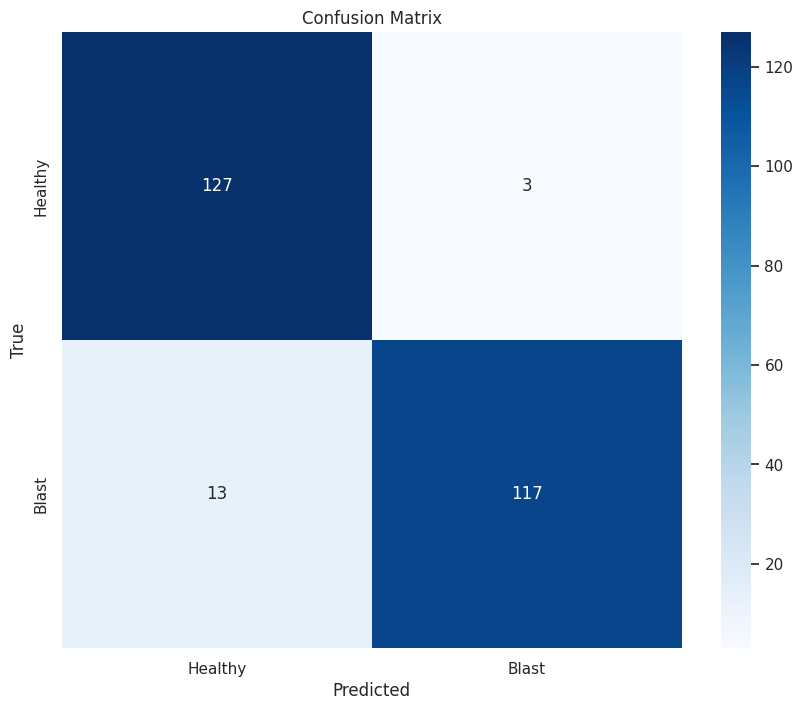

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['Healthy', 'Blast'])


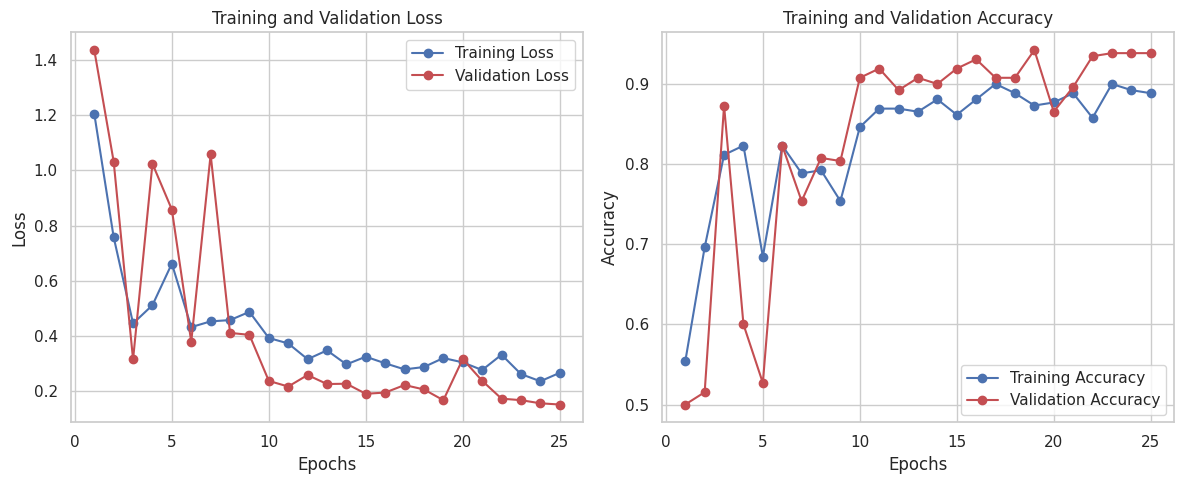

In [10]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


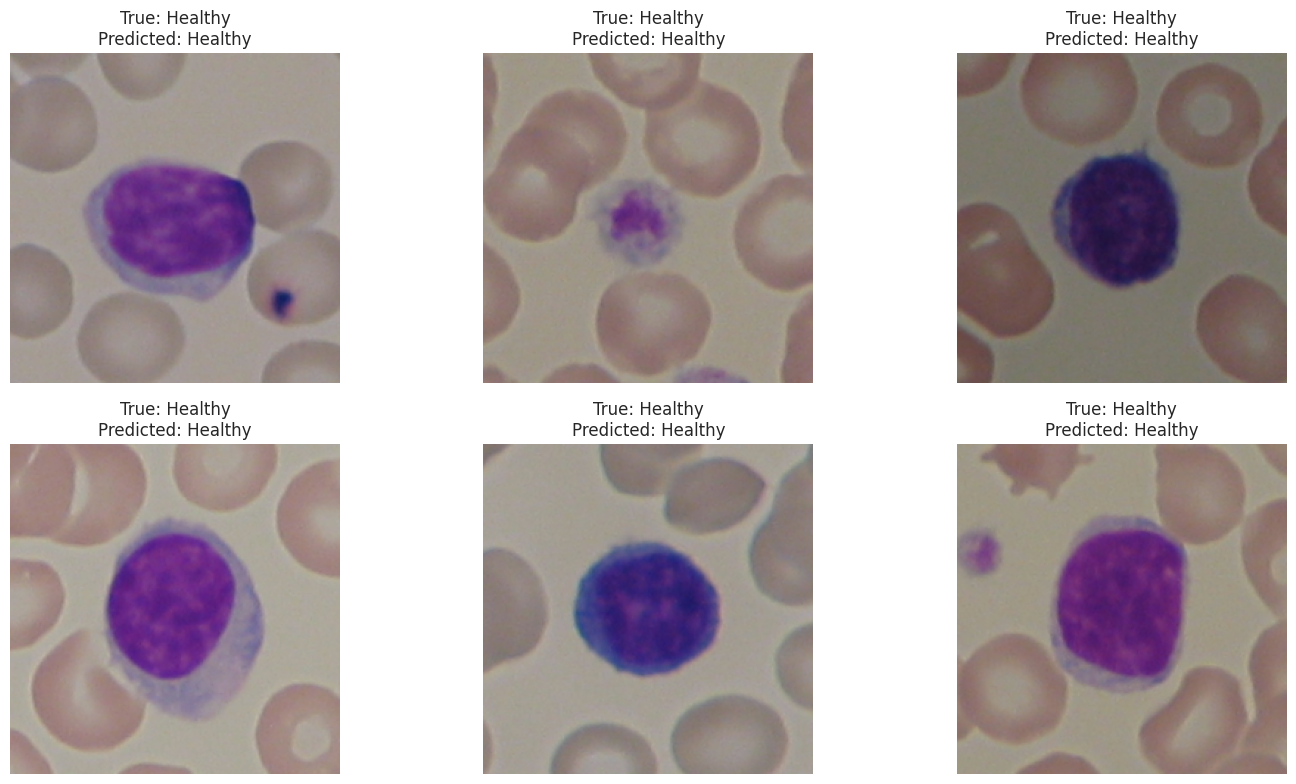

In [11]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Display each image with true and predicted labels
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)  # Un-normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['Healthy', 'Blast'], num_images=6)

